Number of data points in each classification:
A300: 34
A310: 33
A320: 133
A330: 67
A340: 133
A380: 34
ATR-42: 33
ATR-72: 33
An-12: 34
BAE 146: 66
BAE-125: 34
Beechcraft 1900: 33
Boeing 707: 34
Boeing 717: 33
Boeing 727: 33
Boeing 737: 267
Boeing 747: 133
Boeing 757: 67
Boeing 767: 100
Boeing 777: 66
C-130: 34
C-47: 33
CRJ-200: 33
CRJ-700: 67
Cessna 172: 33
Cessna 208: 34
Cessna Citation: 66
Challenger 600: 34
DC-10: 33
DC-3: 33
DC-6: 34
DC-8: 33
DC-9: 33
DH-82: 34
DHC-1: 33
DHC-6: 33
DR-400: 33
Dash 8: 67
Dornier 328: 34
EMB-120: 33
Embraer E-Jet: 100
Embraer ERJ 145: 67
Embraer Legacy 600: 33
Eurofighter Typhoon: 33
F-16: 34
F/A-18: 33
Falcon 2000: 33
Falcon 900: 34
Fokker 100: 33
Fokker 50: 33
Fokker 70: 34
Global Express: 33
Gulfstream: 67
Hawk T1: 33
Il-76: 33
King Air: 34
L-1011: 34
MD-11: 33
MD-80: 67
MD-90: 33
Metroliner: 33
PA-28: 33
SR-20: 33
Saab 2000: 34
Saab 340: 33
Spitfire: 33
Tornado: 34
Tu-134: 33
Tu-154: 33
Yak-42: 34
Selected Labels: {'Boeing 737': 0, 'Boeing 747': 1,

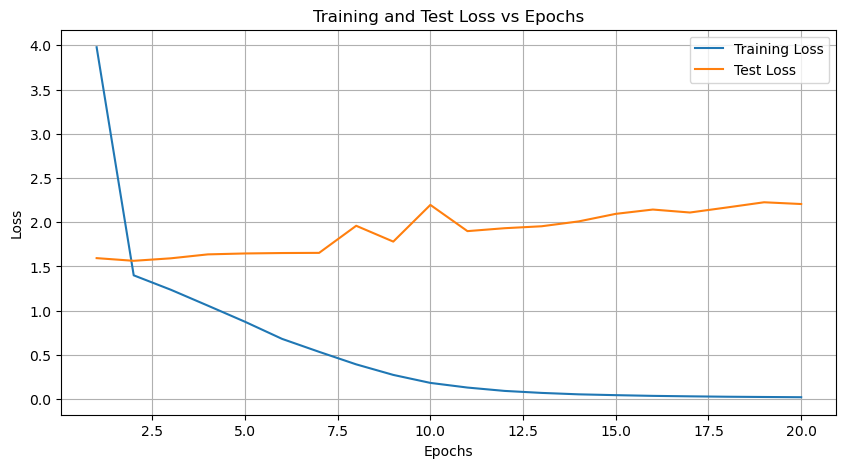

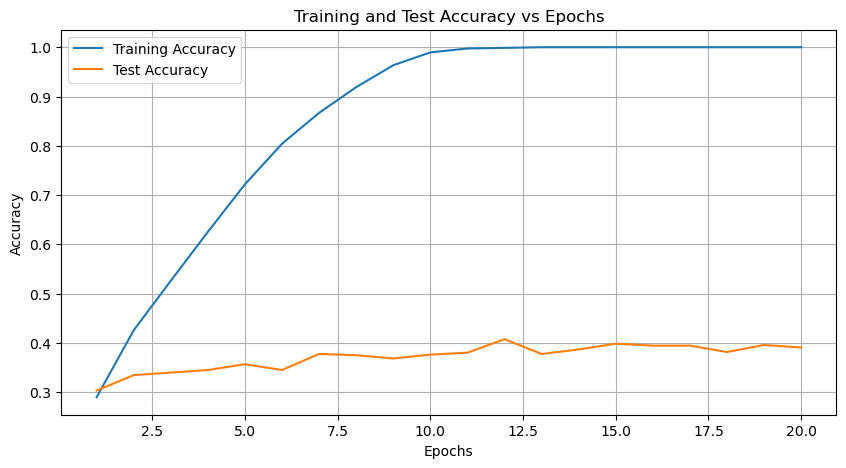

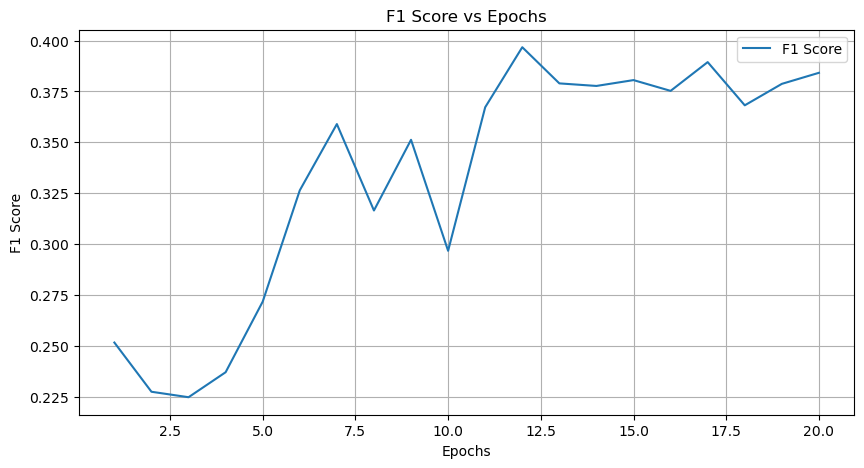

In [3]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score

# Define the folder containing the images
image_folder = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

# Paths to the text files
train_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_train.txt'
test_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_test.txt'
val_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_trainval.txt'

# Define label mapping
label_mapping = {
    "Boeing 707": 0,
    "Boeing 727": 1,
    "Boeing 737": 2,
    "Boeing 747": 3,
    "Boeing 757": 4,
    "Boeing 767": 5,
    "Boeing 777": 6,
    "A300": 7,
    "A310": 8,
    "A320": 9,
    "A330": 10,
    "A340": 11,
    "A380": 12,
    "ATR-42": 13,
    "ATR-72": 14,
    "An-12": 15,
    "BAE 146": 16,
    "BAE-125": 17,
    "Beechcraft 1900": 18,
    "Boeing 717": 19,
    "C-130": 20,
    "C-47": 21,
    "CRJ-200": 22,
    "CRJ-700": 23,
    "Cessna 172": 24,
    "Cessna 208": 25,
    "Cessna Citation": 26,
    "Challenger 600": 27,
    "DC-10": 28,
    "DC-3": 29,
    "DC-6": 30,
    "DC-8": 31,
    "DC-9": 32,
    "DH-82": 33,
    "DHC-1": 34,
    "DHC-6": 35,
    "Dash 8": 36,
    "DR-400": 37,
    "Dornier 328": 38,
    "Embraer E-Jet": 39,
    "EMB-120": 40,
    "Embraer ERJ 145": 41,
    "Embraer Legacy 600": 42,
    "Eurofighter Typhoon": 43,
    "F-16": 44,
    "F/A-18": 45,
    "Falcon 2000": 46,
    "Falcon 900": 47,
    "Fokker 100": 48,
    "Fokker 50": 49,
    "Fokker 70": 50,
    "Global Express": 51,
    "Gulfstream": 52,
    "Hawk T1": 53,
    "Il-76": 54,
    "L-1011": 55,
    "MD-11": 56,
    "MD-80": 57,
    "MD-90": 58,
    "Metroliner": 59,
    "King Air": 60,
    "PA-28": 61,
    "SR-20": 62,
    "Saab 2000": 63,
    "Saab 340": 64,
    "Spitfire": 65,
    "Tornado": 66,
    "Tu-134": 67,
    "Tu-154": 68,
    "Yak-42": 69
}

# Count the number of data points in each classification
label_counts = Counter()
with open(train_label_file, "r") as f:
    for line in f:
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            _, label = parts
            label_counts[label] += 1

# Print the number of data points for each classification
print("Number of data points in each classification:")
for label, count in sorted(label_counts.items()):
    print(f"{label}: {count}")

# Select the top 5 labels with the highest counts
top_5_labels = dict(label_counts.most_common(5))
selected_labels = {label: idx for idx, (label, _) in enumerate(top_5_labels.items())}
print("Selected Labels:", selected_labels)

# Define transformations for image processing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(15),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply color jitter
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor

# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor = filter_data(train_label_file, selected_labels)
val_image_tensor, val_label_tensor = filter_data(val_label_file, selected_labels)
test_image_tensor, test_label_tensor = filter_data(test_label_file, selected_labels)

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader
batch_size = 16  # Decreased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders for selected labels created successfully.")

# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 64 * 64, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = self.fc1(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []

# Training loop
num_epochs = 20  # Increased number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}")

print("Training complete.")

# Plotting results
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
